In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [131]:
#load the data and concatenate in "dfall" to process it
train=pd.read_csv('/home/emunnor/train.csv')
test=pd.read_csv('/home/emunnor/test.csv')
dfall = pd.concat([train, test], sort=True).reset_index(drop=True)
#It is easier to have a passenger identifier so we don't deal with duplicate index values. So before doing anything...
dfall.reset_index(inplace=True)
print('Training examples: {}'.format(train.shape[0]))
print('Test examples: {}\n'.format(test.shape[0]))
print(train.columns)
dfall.describe()

Training examples: 891
Test examples: 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,index,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1309.000000,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,654.000000,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,378.020061,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.000000,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,327.000000,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,654.000000,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,981.000000,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,1308.000000,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [132]:
dfall.describe(include=['O'])

,Cabin,Embarked,Name,Sex,Ticket
count,295,1307,1309,1309,1309
unique,186,3,1307,2,929
top,C23 C25 C27,S,"Connolly, Miss. Kate",male,CA. 2343
freq,6,914,2,843,11


In [133]:
dfall.isnull().sum()

index             0
Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

# Missing data
We will deal later with missing Age and Cabin. Fare and Embarked are easy to fill. For **Fare**, let's use the average of the corresponding Pclass

In [134]:
avgPrice = dfall.groupby('Pclass')["Fare"].mean()
print(round(avgPrice,2))
dfall.loc[dfall.Fare.isnull(),'Fare']=round(avgPrice[3],2)

Pclass
1    87.51
2    21.18
3    13.30
Name: Fare, dtype: float64


For the missing **Embarked**, most of people embarked in Southampton, by simple probability the missing values are from there... or we can look for it in https://www.encyclopedia-titanica.org. These are only two values and we have a trustable source. Nice and simple.

In [135]:
embark= dfall.groupby('Embarked')['index'].count()
print(embark)
dfall.loc[dfall.Embarked.isnull(),'Embarked'] = 'S'

Embarked
C    270
Q    123
S    914
Name: index, dtype: int64


# Initial thoughts

From a quick first analysis we can see that the data set size is quite small, so we should really strive to take advantage of all the data and info that we have. There are 3 main causes of survival/mortality.
1st - Getting into a lifeboat. To be saved you shall first reach the lifeboat boarding area, here cabin and Pclass play a role, low class and some cabin numbers are in lower decks, away of lifeboats. 
2nd - Once you reach the lifeboat boarding area, is the biggest filter. A guard evaluates you and decied if you take a lifeboat or wait: "Children and woman go first"... age and gender play a role for sure. And is also a big factor of moral perception. In the movie the bad guy took a baby to look like a father and be saved. Family position should play a role. Is not the same to be a woman, than to be the mother of a toddler and a baby. And of course, the moral evaluation is not absent of rich/poor class perception. Again, Pclass should play a role
3rd - Once you were on a boat, you are in disadvantage if you are old and frail. There is really cold water, injuries, depression, etc. Age plays a role here.

The dataset has 263 fields on age missing, and the agregated fields of Parch and SibSp are not really representative of family position, so we will work to have the most accurate Age estimation we can, and will deagregate Parch and SibSp to have a good family picture of each passenger.

**Errors in dataset.**
While checking outliers and things wrongly identified in feature engineering algorithms I found some errors in the dataset. Checked "encyclopedia-titanica" for the right information and decided to fix the errors here. Fixing the errors from the beginning allow further algorithms to work and save us little reworks. 

In [136]:
dfall.at[[86,147,436,1058],['SibSp','Parch']] = [3,1] #Johnston family were one mom with 4 kids, Ford, Mr. William Neal is Mrs Johnston son.
dfall.at[dfall.Name.str.contains('Ford, Mrs. Edward'),['SibSp','Parch']] = [1,4] #Mrs Johnston was traveling with 4 kids and his sister.
dfall.at[dfall.Name.str.contains('Johnston, Mrs. Andrew G'),['SibSp','Parch']] = [2,2]#Mrs Johnston sister
dfall.loc[dfall.Name=='Newsom, Miss. Helen Monypeny','Name']='Beckwith, Miss. Helen Monypeny'#She is daughter of the Beckwiths
dfall.at[dfall.Name.str.contains('Cavendish, Mrs. Tyrell William'),'Age'] = 25 # Age of Mrs Cavendish was 25.
dfall.at[[746,1283],['SibSp','Parch']] = [1,1] # family Abbot were 2 kids and mom
dfall.at[dfall.Name.str.contains('Abbott, Mrs. Stanton'),['SibSp','Parch']] = [0,2]
dfall.at[[312,1040],['SibSp','Parch']] = [1,0] #Miss Silven was not daughter of Mr/Mrs Lahtinen
dfall.at[dfall.Name=='Silven, Miss. Lyyli Karoliina',['SibSp','Parch']] = [0,0]
dfall.loc[dfall.Name=='Frolicher, Miss. Hedwig Margaritha','Name']='Frolicher-Stehli, Miss. Hedwig Margaritha' #Name is written differently
dfall.loc[[85,206],'Parch']=1 #The Backstroms were traveling with Miss Erna Alexandra as if she was their daughter, let's relate them
dfall.loc[dfall.Name=='Andersson, Miss. Erna Alexandra',['SibSp','Parch','Name']]=[0,2,'Backstrom, Miss. Erna Alexandra']
dfall.loc[dfall.Name=='Nicholls, Mr. Joseph Charles', 'Name']='Davies, Mr. Joseph Charles' #Nichols is Davies' brother, but don't share a common last name
dfall.loc[dfall.Name.str.contains('Hamalainen, Mrs. William'),'Parch']=1 #The Hamalainen/Hiltunen seem like a mom with 2 kids, aren't really related and
dfall.loc[dfall.Name.str.contains('Hamalainen, Master. Viljo'),'SibSp']=0 #Mrs Hamalainen is only 5 years older than Miss Hiltunen, don't really look like
dfall.loc[dfall.Name.str.contains('Hiltunen, Miss. Marta'),['SibSp','Parch']]=[0,0] #mother and daughter.
dfall.loc[dfall.Name.str.contains('Andersson, Miss. Ida Augusta Margareta'),['SibSp','Parch']]=[0,0] #She was traveling alone.
dfall.loc[dfall.Name=='Ahlin, Mrs. Johan (Johanna Persdotter Larsson)','Name']='Petterson, Mrs. Johan (Johanna Persdotter Larsson)' #These 2 were married but kept their
dfall.loc[dfall.Name=='Petterson, Mr. Johan Emil','Name']='Petterson, Mr. Johan'#names, let's relate them
dfall.loc[dfall.Name=='Baxter, Mr. Quigg Edmond','SibSp']= 1 #He is brother of Mary Helene Baxter 
dfall.loc[dfall.Name=='Natsch, Mr. Charles H','Parch']= 0 #He was traveling alone
dfall.loc[dfall.Name=='Newell, Miss. Madeleine','Parch']= 1 #Madeleine and Marjorie were traveling with their dad
dfall.loc[dfall.Name=='Newell, Miss. Marjorie','Parch']= 1
dfall.loc[dfall.Name=='Newell, Miss. Madeleine','Parch']= 1 #Madeleine and Marjorie were traveling with their dad
dfall.loc[dfall.Name=='Madill, Miss. Georgette Alexandra','Name'] = 'Robert, Miss. Georgette Alexandra'
dfall.loc[dfall.Name=='Klasen, Mr. Klas Albin',['SibSp','Parch'] ] = [0,0] #He was traveling with his sister in law and niece.
dfall.loc[dfall.Name=='Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)','Parch'] = 1 #sister-in-law and
dfall.loc[dfall.Name=='Klasen, Miss. Gertrud Emilia','SibSp'] = 0 #niece.


# Let's start
We will use the name extensively to deagregate Parch (Parents or childs) and SibSp (Siblings or spouse), so let's first split the name to start our family picture.

In [137]:
#A regular expression to split the Name in 4 fields
dfall[['NaFirst','NaTitle','NaLast','NaRest']] = dfall['Name'].str.extract('^(.+), (.+?)\. ([\w\s\"]+)?(?:\s*\((.*?)\))?')
#a bit of cleaning is easier here than in the regexp
dfall['NaLast'] = dfall['NaLast'].str.strip()
dfall['NaRest'] = dfall['NaRest'].str.replace('"','')
dfall[['NaFirst','NaTitle','NaLast','NaRest']].isnull().sum()

NaFirst       0
NaTitle       0
NaLast       20
NaRest     1088
dtype: int64

There are titles French, Italian, Spanish, and some other related to nobility or profession. All cases found are over age 23 so, instead of translating, we set those to Mr and Mrs depending on the gender, that way we tackle the tricky ones as "Dr." that can be male or female.

In [138]:
#replacing the abnormal titles with Mr/Mrs depending on gender
abnormal_title = ~dfall['NaTitle'].isin(['Mr', 'Mrs', 'Miss', 'Master'])
dfall.loc[abnormal_title & (dfall.Sex == 'male'), 'NaTitle'] = 'Mr'
dfall.loc[abnormal_title & (dfall.Sex == 'female'), 'NaTitle'] = 'Mrs'
print('Titles in the dataframe: {}'.format(dfall['NaTitle'].unique()))


Titles in the dataframe: ['Mr' 'Mrs' 'Miss' 'Master']


**TA DAAAA!** we have now names nicely split and with standard titles. Let's now assign the family position. For that the interesting fields are ParCh and SibSp, those aggregate number of Parent/Children and Sibling/Spouse. Let's de-agregate them and identify with the index who is the spouse, siblings, parents or children. We will use the following functions to update values in the dataframe. We will start building from the wives. Are easier to identify and... are the center of the family. Right? Wives have the title Mrs, a third name (NaRest), and SibSp > 0, and tipically share the same name and last name with their husbands.

In [139]:
#We will use SibSp1 and Parch1 to substract ocurrences
dfall['SibSp1'] = dfall.SibSp
dfall['Parch1'] = dfall.Parch
dfall['Sp']=""
#this function receives the indexes of the couple and update the fields SibSp1 and Sp for each spouse
def updateSpouse(couple):
    if len(couple) == 2:
        dfall.at[couple[0], 'Sp'] = couple[1]
        dfall.at[couple[0], 'SibSp1'] -= 1
        dfall.at[couple[1], 'Sp'] = couple[0]
        dfall.at[couple[1], 'SibSp1'] -= 1
        
wives = dfall[(dfall['NaTitle'] == 'Mrs') & (~dfall['NaRest'].isnull()) & (dfall['SibSp1']>0)].sort_values(by='Age', ascending=False)
#We will start with a broad search, and add restrictions for further discrimination
for wifeInd, wifeRow in wives.iterrows():
    parentsMask = (dfall['NaFirst']==wifeRow['NaFirst']) & (dfall['NaTitle'].isin(['Mr','Mrs'])) & (dfall['SibSp1']>0)
    coupleDf=dfall.index[(parentsMask)|(dfall.index==wifeInd)]
    updateSpouse(coupleDf)
    if len(coupleDf) >2:
        #if there are more than 1 candidate, we make sure they travel together
        parentsMask &= (dfall['Ticket'] == wifeRow['Ticket'])
        coupleDf = dfall.index[(parentsMask)|(dfall.index==wifeInd)]
        updateSpouse(coupleDf)
        if len(coupleDf) != 2:
        #if we still can't discriminate who is the husband, we look for the same number of kids (Parch1)
            parentsMask &= (dfall['Parch1'] == wifeRow['Parch1'])
            coupleDf = dfall.index[(parentsMask)|(dfall.index==wifeInd)]
            updateSpouse(coupleDf)
            if len(coupleDf) >2:
                print('error with {}'.format(wifeRow['Name']))
print('Couples found:', dfall.loc[dfall.Sp!="",'Sp'].count()/2) 

Couples found: 109.0


In [140]:
#wrongly set as a couple. I found it later while checking outliers. I fix it here to find Hocking's and Petterson's siblings 
dfall.loc[dfall.Name=='Hocking, Mr. Richard George',['SibSp1','Sp']]= [2,""]
dfall.loc[dfall.Name=='Hocking, Mrs. Elizabeth (Eliza Needs)',['SibSp1','Sp']]= [1,""]
dfall.loc[dfall.Name=='Petterson, Mr. Johan',['SibSp1','Sp']] = [1,""]
dfall.loc[dfall.Name.str.contains('Petterson, Mrs. Johan '),['SibSp1','Sp']] = [1,""]

In [141]:
dfall['Sib']=""
#This function receives a set of indexes to update Sib and SibSp1    
def updateSiblings(siblings):
    if len(siblings)>1:
        sibStr = ', '.join(map(str, siblings))
        for sibIndex in siblings:
            dfall.at[sibIndex, 'Sib'] = sibStr
            dfall.at[sibIndex, 'SibSp1'] -= (len(siblings)-1)

#These are the possible siblings, since we already removed the Spouses
siblings = dfall[(dfall.SibSp1>0)]
print('initial candidate siblings', siblings.SibSp1.count())
for sibInd, sibRow in siblings.iterrows():
    #first we look for the ones with the same last name
    sibMask = (dfall.SibSp1==sibRow['SibSp1']) &\
        (dfall.Name.str.contains(sibRow['NaFirst']))
    sibDf=dfall.index[sibMask]
    if len(sibDf)==(sibRow['SibSp1']+1):
        updateSiblings(sibDf)
    elif pd.isna(sibRow['NaRest']) :
        #If not sure, we look further for the ones with the same ticket number
        sibMask &= (dfall.Ticket==sibRow['Ticket'])
        sibDf=dfall.index[sibMask]
        if len(sibDf)==(sibRow['SibSp1']+1):
            updateSiblings(sibDf)
    else:
        #If not, then look for the rest of the name, maybe they changed last name when marrying
        sibMask = (dfall.SibSp1==sibRow['SibSp1']) &\
            (dfall.Name.str.contains(sibRow['NaRest'].split()[-1]))
        sibDf=dfall.index[sibMask]
        if len(sibDf)==(sibRow['SibSp1']+1):
            updateSiblings(sibDf)

siblings = dfall[(dfall.SibSp1>0)].sort_values('Ticket')
print('Final candidate siblings', siblings.SibSp1.count())
print(siblings)

initial candidate siblings 208
Final candidate siblings 0
Empty DataFrame
Columns: [index, Age, Cabin, Embarked, Fare, Name, Parch, PassengerId, Pclass, Sex, SibSp, Survived, Ticket, NaFirst, NaTitle, NaLast, NaRest, SibSp1, Parch1, Sp, Sib]
Index: []

[0 rows x 21 columns]


In [142]:
dfall['Dad']=""
dfall['Mom']=""
dfall['Ch']=""
#this receives indexes for parents and kids and relate them 
def updateParentChild(parents, kids):
    kidsStr = ', '.join(map(str, kids))
    numOfParents = len(parents)
    numOfKids = len(kids)
    for parent in parents:
        dfall.at[parent, 'Ch'] = kidsStr
        dfall.at[parent, 'Parch1'] -= numOfKids
        if dfall.at[parent, 'Sex'] == 'male':
            for kid in kids:
                dfall.at[int(kid), 'Dad'] = parent
                dfall.at[int(kid), 'Parch1'] -= 1
        else:
            for kid in kids:
                dfall.at[int(kid), 'Mom'] = parent
                dfall.at[int(kid), 'Parch1'] -= 1

def loopInKids(kids):
    for kidInd, kidRow in kids.iterrows():
        if kidRow['Sib']:
            kidsDf = pd.Int64Index([int(idx.strip()) for idx in kidRow['Sib'].split(',')])
        else:
            kidsDf = {kidInd}
        parentMask = (dfall.Name.str.contains(kidRow['NaFirst'])) & (~dfall.index.isin(kidsDf)) &\
                    (dfall.Parch1>0) & (dfall.NaTitle.isin(['Mr','Mrs']))
        parentsDf = dfall.index[parentMask]
        if len(parentsDf) == dfall.at[kidInd,'Parch1']:
            updateParentChild(parentsDf, kidsDf)
        elif len(parentsDf) > dfall.at[kidInd,'Parch1']:
            parentMask &= (dfall.Ticket==kidRow['Ticket'])
            parentsDf = dfall.index[parentMask]
            if len(parentsDf) == dfall.at[kidInd,'Parch1']:
                updateParentChild(parentsDf, kidsDf)
#             else:
#                 print('Many parents for {} expected {} but found {}'.format(kidRow['Name'],kidRow['Parch1'],len(parentsDf)))
#         else:
#             print('Too few parents for {} expected {} but found {}'.format(kidRow['Name'],kidRow['Parch1'],len(parentsDf)))
        
#We will look first in kids and look for their parents
parchLess = dfall[(dfall.Parch1>0)]
print('initial people missing parents/children', parchLess.Parch1.count()/2)
kids = dfall[(dfall.NaTitle.isin(['Miss','Master'])) & (dfall.Parch1>0)].sort_values('Age')
loopInKids(kids)
#Then in not so kids, but still unmarried
kids = dfall[(dfall.Parch1>0) & (dfall.Sp=="")].sort_values('Age')
loopInKids(kids)
#Then the rest
kids = dfall[(dfall.Parch1>0)].sort_values('Age')
loopInKids(kids)
parchLess = dfall[(dfall.Parch1>0)]
print('final people missing parents/children', parchLess.Parch1.count()/2)
print(parchLess.Name)

initial people missing parents/children 152.0
final people missing parents/children 0.5
983    Davidson, Mrs. Thornton (Orian Hays)
Name: Name, dtype: object


In [143]:
#While checking outliers, I found that these were wrongly classified due to the single name of Orian Hays
dfall.at[820,['Dad','Ch','Parch1']]=['','983',0]
dfall.at[983,['Dad','Mom','Ch','Parch1']]=[1199,820,'',0]
dfall.at[1199,['Mom','Ch','Parch1']]=['','983',0]
dfall.at[259,['Mom','Ch']] = ['','880']
dfall.at[880,['Mom','Ch']] = [259,'']
dfall.at[879,['Mom','Ch']] = ['','1041']
dfall.at[1041,['Mom','Ch']] = [879,'']

**Family ties are now untangled!** Let's start seeing some actual data. Most of the missing data is on "Age". We will take two courses of action:
1. Estimate an unknown age based on some relative with known age. i.e. A man with unknown age is married with a girl of 35. He will probably will be around 40, since, the average difference between husband and wife is 4.61 years. So we need to know average difference between husband-wife, and parent-children.
2. Use a neural network, where Y is the age.

In [144]:
#estimating difference in age between husband and wife
dfall['difAgeMomDad']=""

def ageDifference(row):
    if pd.notna(row['Age']):
        spouseAge = dfall.at[row['Sp'], 'Age']
        if pd.notna(spouseAge):
            return row['Age'] - spouseAge

marriedMen=(dfall.Sp!="") & (dfall.Sex=='male')
dfall.loc[marriedMen,'difAgeMomDad']=dfall[marriedMen].apply(ageDifference, axis=1)
print('{} cases processed'.format(dfall[marriedMen].count()[0]))

107 cases processed


In [145]:
#estimating difference in age between kids and mom/dad
dfall['difAgeMom']=""
dfall['difAgeDad']=""

def difAgeParch(row):
    if pd.notna(row['Age']):
        if (row['Dad']!=""):
            if pd.notna(dfall.at[row['Dad'], 'Age']):
                dfall.at[row.name, 'difAgeDad'] = dfall.at[row['Dad'], 'Age']-row['Age']
        if (row['Mom']!=""):
            if pd.notna(dfall.at[row['Mom'], 'Age']):
                dfall.at[row.name, 'difAgeMom'] = dfall.at[row['Mom'], 'Age']-row['Age']

son=(dfall.Dad!="")|(dfall.Mom!="")
dfall[son].apply(difAgeParch, axis=1)
print('{} cases processed'.format(dfall[son].count()[0]))

174 cases processed


The following plots were used to identify outliers and correct whatever is needed.

Average difference between mom and dad: 4.612903225806452


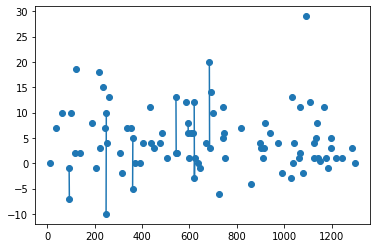

In [146]:
dfall['toPlot'] = pd.to_numeric(dfall['difAgeMomDad'], errors='coerce')
plt.plot(dfall['toPlot'], marker='o', linestyle='-')
avgAgeDifHusWif=dfall['toPlot'].mean()
print("Average difference between mom and dad:",avgAgeDifHusWif)

Average difference between dad and kids: 31.037236842105262


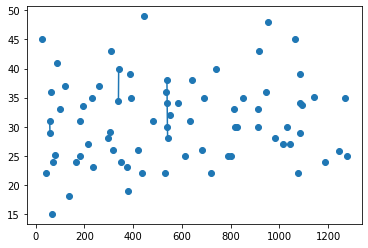

In [147]:
dfall['toPlot'] = pd.to_numeric(dfall['difAgeDad'], errors='coerce')
plt.plot(dfall['toPlot'], marker='o', linestyle='-')
avgDifAgeDad=dfall['toPlot'].mean()
print("Average difference between dad and kids:",avgDifAgeDad)

Average difference between mom and kids: 27.761703703703702


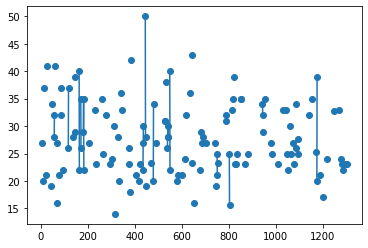

In [148]:
dfall['toPlot'] = pd.to_numeric(dfall['difAgeMom'], errors='coerce')
plt.plot(dfall['toPlot'], marker='o', linestyle='-')
avgDifAgeMom=dfall['toPlot'].mean()
print("Average difference between mom and kids:",avgDifAgeMom)

We have the id's of each family member, let's make it more readable for an input layer of a neural network. Instead of a value in "spouse" we will have a column "Married" with 0 for single and 1 for married. Instead of "Sex" with values Male and Female a column "Gender" with 0 for male and 1 for female, etc.

In [149]:
def countElements(cell):
    if cell == '':
        return 0
    else:
        return len(str(cell).split(','))
    
def countSiblings(cell):
    if cell == '':
        return 0
    else:
        return len(cell.split(','))-1

dfall['Married'] = dfall['Sp'].apply(lambda x: 1 if pd.notna(x) and x != '' else 0)
dfall['SibNum'] = dfall['Sib'].apply(countSiblings)
dfall['HasDad'] = dfall['Dad'].apply(lambda x: 1 if pd.notna(x) and x != '' else 0)
dfall['HasMom'] = dfall['Mom'].apply(lambda x: 1 if pd.notna(x) and x != '' else 0)
dfall['ChNum'] = dfall['Ch'].apply(countElements)
dfall = pd.get_dummies(dfall, columns=['NaTitle'], prefix=['Tit'])
dfall['Gender']=0
dfall.loc[dfall.Sex=='female','Gender']=1

In [150]:
#a bit of cleaning since we don't need these columns any longer
dfall.drop(['PassengerId','Sex','Parch','SibSp','NaFirst', 'NaLast', 'NaRest','SibSp1', 'Parch1','difAgeMomDad',
       'difAgeMom', 'difAgeDad', 'toPlot'], axis=1, inplace=True)

In [151]:
#now we split data to have a training set
toFillAge=dfall[dfall.Age.isna()]
x_trainAge=dfall[dfall.Age.notna()]
y_trainAge=x_trainAge['Age']
print(toFillAge.shape, x_trainAge.shape, y_trainAge.shape)

(263, 24) (1046, 24) (1046,)


From here we can see which columns may be useful as inputs to our neural network to estimate the age of the NaN cases.

In [152]:
dfTrainAgeCorr = x_trainAge.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
print(dfTrainAgeCorr.loc[dfTrainAgeCorr.level_0=='Age'])

    level_0     level_1         0
2       Age         Age  1.000000
38      Age      HasMom  0.508213
44      Age      Pclass  0.405218
47      Age  Tit_Master  0.392385
57      Age      SibNum  0.359631
59      Age      HasDad  0.353650
70      Age    Tit_Miss  0.281706
82      Age      Tit_Mr  0.241167
87      Age     Married  0.232827
92      Age       ChNum  0.213540
94      Age     Tit_Mrs  0.212383
105     Age        Fare  0.175775
172     Age    Survived  0.077221
178     Age      Gender  0.068385
206     Age       index  0.025958


In [153]:
#Here I droped the columns that didn't provided much info to age estimation 
toDrop = ['index','Name','Age', 'Survived', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sp', 'Sib', 'Dad', 'Mom', 'Ch']
x_trainAge.drop(toDrop, axis=1, inplace=True)
toFillAge.drop(toDrop, axis=1, inplace=True)
print(toFillAge.shape, x_trainAge.shape, y_trainAge.shape)

(263, 11) (1046, 11) (1046,)


/home/emunnor/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [154]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x_trainAge, y_trainAge, test_size=0.2, random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(X_train, y_train, epochs=55, batch_size=16, validation_data=(X_val, y_val), verbose=1)

nn_val_pred = model.predict(X_val)
nn_val_mae = mean_absolute_error(y_val, nn_val_pred)
print("MAE: {:.2f}".format(nn_val_mae))


Epoch 1/55
43/53 [=======================>......] - ETA: 0s - loss: 28.8660 

53/53 [==============================] - 0s 4ms/step - loss: 28.3364 - val_loss: 22.3691
Epoch 2/55
53/53 [==============================] - 0s 2ms/step - loss: 17.1088 - val_loss: 11.6498
Epoch 3/55
53/53 [==============================] - 0s 2ms/step - loss: 12.0999 - val_loss: 9.7057
Epoch 4/55
53/53 [==============================] - 0s 2ms/step - loss: 10.8033 - val_loss: 8.4836
Epoch 5/55
53/53 [==============================] - 0s 2ms/step - loss: 9.6284 - val_loss: 8.0312
Epoch 6/55
53/53 [==============================] - 0s 2ms/step - loss: 8.7931 - val_loss: 7.4060
Epoch 7/55
53/53 [==============================] - 0s 2ms/step - loss: 8.2130 - val_loss: 7.2354
Epoch 8/55
53/53 [==============================] - 0s 2ms/step - loss: 8.0029 - val_loss: 7.4375
Epoch 9/55
53/53 [==============================] - 0s 2ms/step - loss: 7.9267 - val_loss: 7.1666
Epoch 10/55
53/53 [==============================] - 0s 2ms/step - loss: 7.9666 - val_loss: 7.1028
Epoch 11/55
53/53 [=====

We have now our neural network trained, we will predict missing Age values and put those in a column "newAge". 

In [155]:
nn_val_pred = model.predict(toFillAge)
dfall['newAge']=""
dfall.loc[dfall.Age.isna(),'newAge'] = nn_val_pred

Now we can implement algorithm number 1 to estimate missing ages based on relatives with known ages.

In [156]:
def estimateAge(row):
    myAge=[]
    if (row['Dad'] != ""):
        if pd.notna(dfall.at[row['Dad'], 'Age']):
            myAge.append(dfall.at[row['Dad'], 'Age'] - avgDifAgeDad)
    if (row['Mom'] != ""):
        if pd.notna(dfall.at[row['Mom'], 'Age']):
            myAge.append(dfall.at[row['Mom'], 'Age'] - avgDifAgeMom)
    if (row['Sp'] != ""):
        if pd.notna(dfall.at[row['Sp'], 'Age']):
            if row['Gender'] == 0:
                myAge.append(dfall.at[row['Sp'], 'Age'] + avgAgeDifHusWif)
            else:
                myAge.append(dfall.at[row['Sp'], 'Age'] - avgAgeDifHusWif)
    if (row['Sib'] != ""):
        kidsDf = pd.Int64Index([int(idx.strip()) for idx in row['Sib'].split(',')])
        for kid in kidsDf:
            if pd.notna(dfall.at[kid, 'Age']):
                myAge.append(dfall.at[kid, 'Age'])
    if (row['Ch'] != ""):
        kidsDf = pd.Int64Index([int(idx.strip()) for idx in row['Ch'].split(',')])
        ageToSum = avgDifAgeMom if row['Gender'] == 1 else avgDifAgeDad
        for kid in kidsDf:
            if pd.notna(dfall.at[kid, 'Age']):
                myAge.append(dfall.at[kid, 'Age']+ageToSum)
    if len(myAge) > 0:
        print('{} has estimated age:{}'.format(row['Name'],round(sum(myAge)/len(myAge))))
        return round(sum(myAge)/len(myAge))

iniMisAge=dfall.loc[dfall.Age.isna(), 'index'].count()
print("Initial number of missing age:{}".format(iniMisAge))
finMisAge = 0
while iniMisAge != finMisAge:
    finMisAge = iniMisAge
    dfall.loc[dfall.Age.isna(),'Age']=dfall[dfall.Age.isna()].apply(estimateAge, axis=1)
    iniMisAge=dfall.loc[dfall.Age.isna(), 'index'].count()
    
print("Final number of missing age:{}".format(dfall.loc[dfall.Age.isna(), 'index'].count()))

Initial number of missing age:263
Spencer, Mrs. William Augustus (Marie Eugenie) has estimated age:52
Boulos, Mrs. Joseph (Sultana) has estimated age:35
Sage, Master. Thomas Henry has estimated age:14
Chibnall, Mrs. (Edith Martha Bowerman) has estimated age:50
Sage, Miss. Constance Gladys has estimated age:14
Sage, Mr. Frederick has estimated age:14
Zabour, Miss. Thamine has estimated age:14
Sage, Mr. George John Jr has estimated age:14
Frauenthal, Mrs. Henry William (Clara Heinsheimer) has estimated age:45
Meyer, Mrs. Edgar Joseph (Leila Saks) has estimated age:23
Kenyon, Mrs. Frederick R (Marion) has estimated age:36
Bourke, Miss. Mary has estimated age:7
Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright) has estimated age:43
Sage, Miss. Stella Anna has estimated age:14
Sage, Mr. Douglas Bullen has estimated age:14
Goldenberg, Mrs. Samuel L (Edwiga Grabowska) has estimated age:44
Sage, Miss. Dorothy Edith "Dolly" has estimated age:14
Johnston, Mrs. Andrew G (Elizabeth Lily" Watson)" h

In [157]:
dfall.loc[(dfall.Age.isna()),'Age'] = dfall['newAge']
dfall['Age'] = dfall['Age'].apply(lambda x: round(float(x), 2))

We have now accurate ages! at least way more accurate than a simple average. And the best of it: the position of each passenger in a family.

# Family members survived or died?
We have at least partial information of who survived or not. This can be important, so let's fill it up. If we know that the mom of the passenger survived, we will set "SurvMom" to 1, if we know that she died set this to -1 and if we don't know we will leave it at 0. The same for Dad, kids, siblings and spouse/partner.

In [158]:
dfall['SurvMom']=0
dfall['SurvDad']=0
dfall['SurvKids']=0
dfall['SurvSibs']=0
dfall['SurvPar']=0

def fillSurvived(survivor):
    if survivor['Survived'] ==1:
        adder=1
    else:
        adder=-1
    if survivor['Mom'] != "":
        dfall.at[survivor['Mom'],'SurvKids'] += adder
    if survivor['Dad'] != "":
        dfall.at[survivor['Dad'],'SurvKids'] += adder
    if survivor['Sp'] != "":
        dfall.at[survivor['Sp'],'SurvPar'] = adder
    if (survivor['Ch'] != ""):
        childrenDf = pd.Int64Index([int(idx.strip()) for idx in survivor['Ch'].split(',')])
        for child in childrenDf:
            if survivor['Gender'] == 0:
                dfall.at[child,'SurvDad'] += adder
            else:
                dfall.at[child,'SurvMom'] += adder
    if (survivor['Sib'] != ""):
        sibDf = pd.Int64Index([int(idx.strip()) for idx in survivor['Sib'].split(',')])
        for sib in sibDf:
            dfall.at[sib,'SurvSibs'] += adder

dfall[dfall.Survived.notna()].apply(fillSurvived, axis=1)
print('{} cases processed'.format(dfall[dfall.Survived.notna()].count()[0]))

891 cases processed


The cabin can give us information of where the passenger was located at the time of the accident. So let's extract the deck identifier, and if the number is pair or odd. Pair numbers were at starboard side. Does this play a factor? Let's see.

In [159]:
#Extracting data from Cabin
dfall['Deck']=dfall['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'X')
dfall['CabinNumber']=dfall['Cabin'].str.extract('[\w](\d+)')
dfall['CabinNumber'] = pd.to_numeric(dfall['CabinNumber'], errors='coerce')
dfall['LeftRight'] = dfall['CabinNumber'].apply(lambda x: 2 if pd.isnull(x) else (1 if x % 2 != 0 else 0))
dfall.drop(columns=['CabinNumber'], inplace=True)

Now that we have engineered a couple of features, we can split the "all" set into train and test, to analyze factors affecting survival rate.

In [160]:
train=dfall[:890]
test=dfall[891:].drop(['Survived'],axis=1)

In [161]:
dfSurvCorr = train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
print(dfSurvCorr.loc[dfSurvCorr.level_0=='Survived'])

      level_0     level_1         0
14   Survived    Survived  1.000000
35   Survived      Tit_Mr  0.566200
41   Survived      Gender  0.543053
73   Survived     Tit_Mrs  0.359257
77   Survived      Pclass  0.337996
82   Survived    Tit_Miss  0.326805
92   Survived    SurvSibs  0.294445
99   Survived   LeftRight  0.275384
105  Survived     SurvMom  0.257972
109  Survived        Fare  0.256995
190  Survived    SurvKids  0.145268
205  Survived     Married  0.124628
215  Survived      HasMom  0.117227
253  Survived      SibNum  0.088982
262  Survived  Tit_Master  0.085060
272  Survived      HasDad  0.080099
300  Survived         Age  0.054968
336  Survived     SurvDad  0.030070
359  Survived     SurvPar  0.023755
370  Survived       ChNum  0.018536
423  Survived       index  0.003479


There are expected correlations with survival as gender, title, class, and surviving mother/siblings

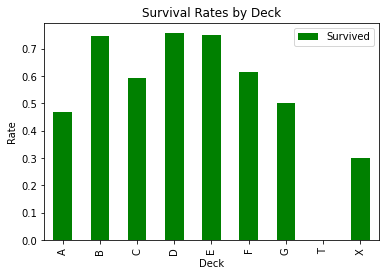

In [162]:
survRate = train.groupby('Deck')['Survived'].mean() 

fig, ax = plt.subplots()
survRate.plot(kind='bar', ax=ax, color='green', label='Survived')
ax.set_ylabel('Rate')
ax.set_xlabel('Deck')
ax.set_title('Survival Rates by Deck')
ax.legend()

plt.show()

LeftRight
0    0.611111
1    0.739130
2    0.301449
Name: Survived, dtype: float64


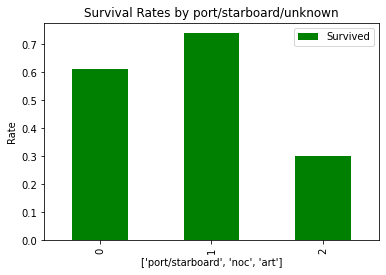

In [163]:
survRate = train.groupby('LeftRight')['Survived'].mean() 
print(survRate)
fig, ax = plt.subplots()
survRate.plot(kind='bar', ax=ax, color='green', label='Survived')
ax.set_ylabel('Rate')
ax.set_xlabel(['port/starboard','noc','art'])
ax.set_title('Survival Rates by port/starboard/unknown')
ax.legend()

Tit_Master  Tit_Miss  Tit_Mr  Tit_Mrs
0           0         0       1          0.803030
                      1       0          0.160448
            1         0       0          0.697802
1           0         0       0          0.575000
Name: Survived, dtype: float64


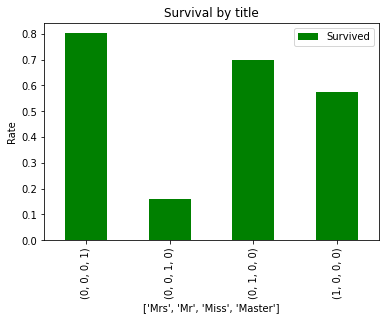

In [164]:
survRate = train.groupby(['Tit_Master', 'Tit_Miss','Tit_Mr', 'Tit_Mrs'])['Survived'].mean() 
print(survRate)
fig, ax = plt.subplots()
survRate.plot(kind='bar', ax=ax, color='green', label='Survived')
ax.set_ylabel('Rate')
ax.set_xlabel(['Mrs','Mr','Miss','Master'])
ax.set_title('Survival by title')
ax.legend()

Gender
0    0.189236
1    0.742038
Name: Survived, dtype: float64


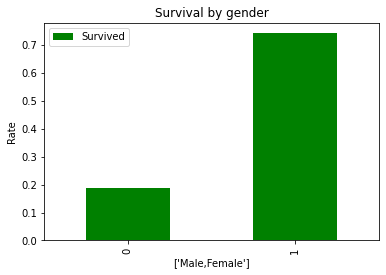

In [165]:
survRate = train.groupby('Gender')['Survived'].mean() 
print(survRate)
fig, ax = plt.subplots()
survRate.plot(kind='bar', ax=ax, color='green', label='Survived')
ax.set_ylabel('Rate')
ax.set_xlabel(['Male,Female'])
ax.set_title('Survival by gender')
ax.legend()

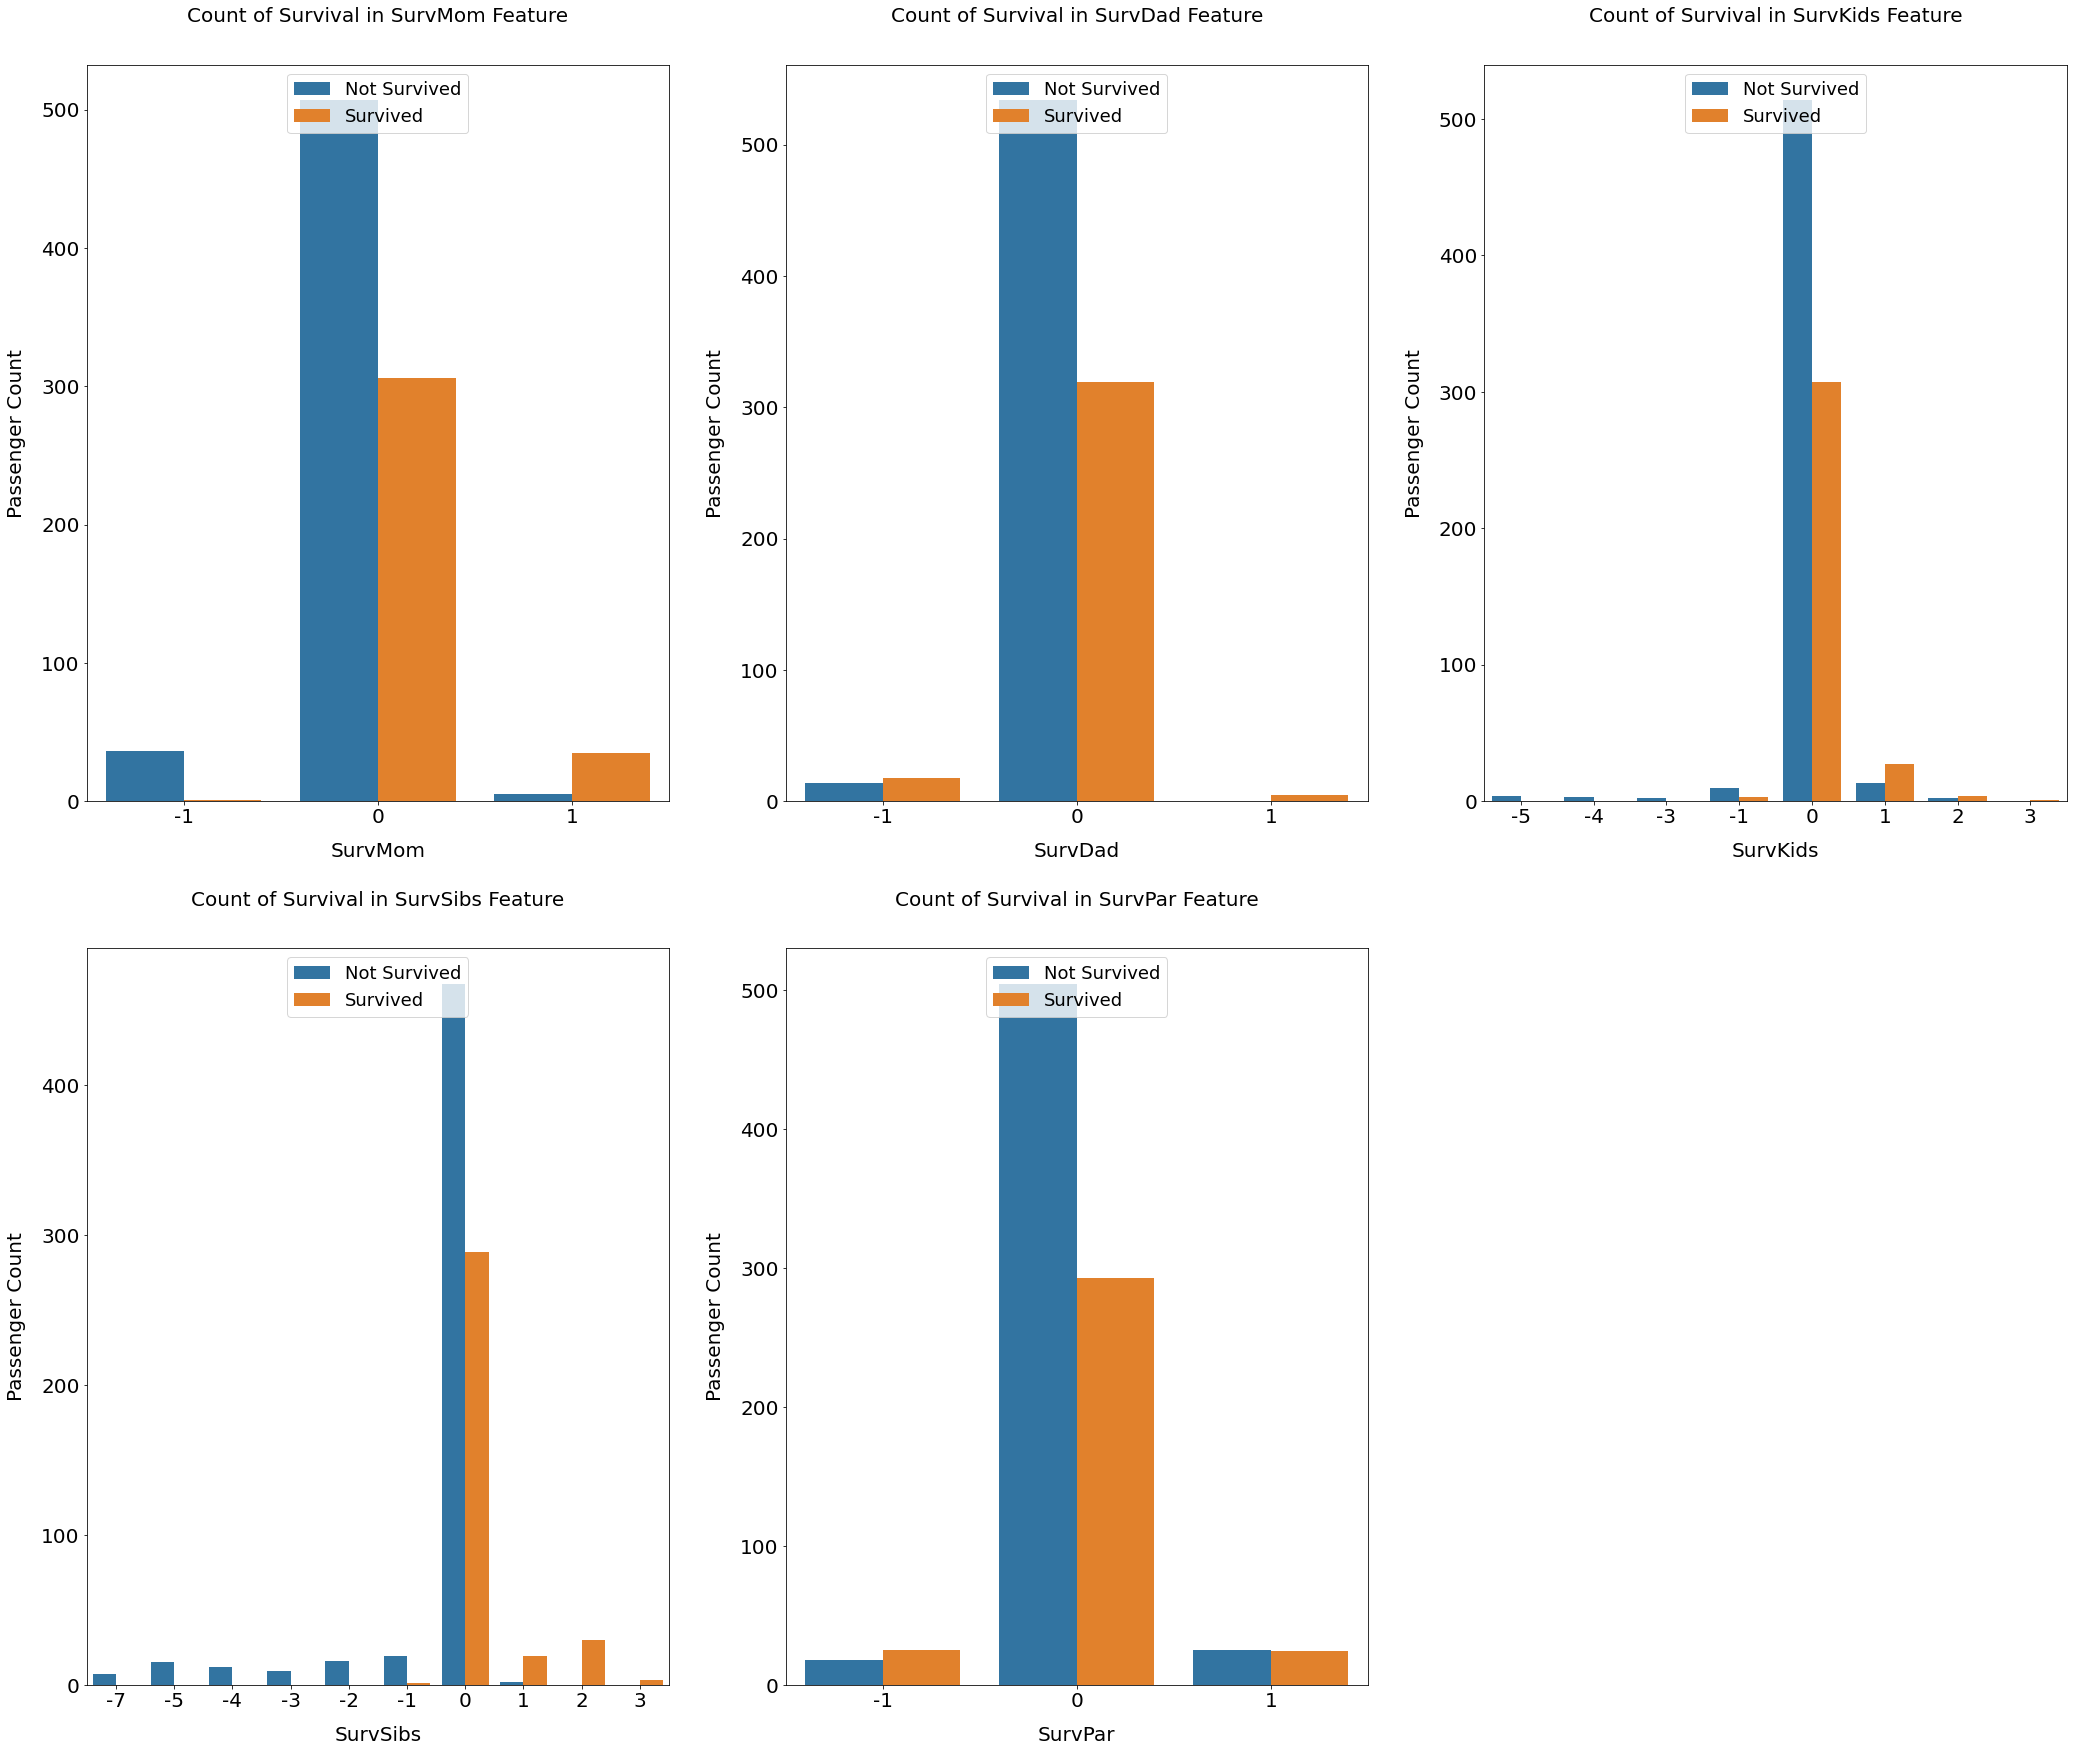

In [166]:
import seaborn as sns
cat_features = ['SurvMom', 'SurvDad', 'SurvKids', 'SurvSibs','SurvPar']
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

Once we analyzed our data, let's optimize it. In the aggregated dataframe we get the dummies, check the correlations with Survived, delete what doesn't correlate a lot or that are directly correlated, and choose which fields to keep iteratively.

In [167]:
dfall = pd.get_dummies(dfall, columns=['SurvMom'], prefix=['SurMom'])
dfall = pd.get_dummies(dfall, columns=['SurvDad'], prefix=['SurDad'])
dfall = pd.get_dummies(dfall, columns=['Deck'], prefix=['Deck'])
dfall = pd.get_dummies(dfall, columns=['LeftRight'], prefix=['Side'])
toDrop = ['index', 'Survived','Cabin', 'Embarked', 'Name', 'Ticket','Sp', 'Sib', 'Dad', 'Mom','newAge', 'Ch','HasDad', 'HasMom','SibNum','ChNum','SurvPar']

In [168]:
dfTrainCorr = dfall.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
print(dfTrainCorr.loc[dfTrainCorr.level_0=='Survived'])

       level_0     level_1         0
23    Survived    Survived  1.000000
79    Survived      Tit_Mr  0.566512
84    Survived      Gender  0.543351
145   Survived     Tit_Mrs  0.359466
165   Survived      Pclass  0.338481
170   Survived    Tit_Miss  0.327093
181   Survived      Deck_X  0.316912
182   Survived      Side_2  0.316567
202   Survived    SurvSibs  0.294201
230   Survived        Fare  0.257307
235   Survived      Side_1  0.247905
280   Survived    SurMom_1  0.218962
346   Survived      Deck_B  0.175095
348   Survived      Side_0  0.173563
371   Survived   SurMom_-1  0.152718
378   Survived      Deck_D  0.150716
395   Survived      Deck_E  0.145321
397   Survived    SurvKids  0.145225
433   Survived     Married  0.124953
462   Survived      HasMom  0.117524
472   Survived      Deck_C  0.114652
496   Survived    SurDad_0  0.101773
506   Survived    SurDad_1  0.095179
535   Survived      SibNum  0.088648
552   Survived  Tit_Master  0.085221
574   Survived      HasDad  0.080316
6

In [169]:
train=dfall[:890]
test=dfall[891:]
train.columns

Index(['index', 'Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Pclass',
       'Survived', 'Ticket', 'Sp', 'Sib', 'Dad', 'Mom', 'Ch', 'Married',
       'SibNum', 'HasDad', 'HasMom', 'ChNum', 'Tit_Master', 'Tit_Miss',
       'Tit_Mr', 'Tit_Mrs', 'Gender', 'newAge', 'SurvKids', 'SurvSibs',
       'SurvPar', 'SurMom_-1', 'SurMom_0', 'SurMom_1', 'SurDad_-1', 'SurDad_0',
       'SurDad_1', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_X', 'Side_0', 'Side_1', 'Side_2'],
      dtype='object')

<AxesSubplot:>

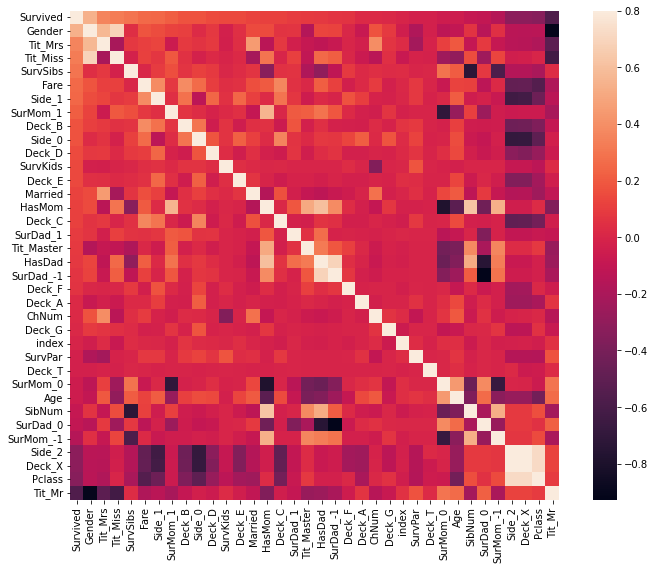

In [170]:

corrmat = train.corr()
survived_corr = corrmat['Survived'].sort_values(ascending=False)
sorted_corrmat = corrmat.loc[survived_corr.index, survived_corr.index]
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(sorted_corrmat, vmax=.8, square=True)

In [185]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(train.drop(columns=toDrop))
y_train = train['Survived'].values
X_test = StandardScaler().fit_transform(test.drop(columns=toDrop))
dfall.drop(columns=toDrop, inplace=True)
print( X_train.shape, y_train.shape, X_test.shape )

(890, 29) (890,) (418, 29)


In [195]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
SEED=42
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 

In [196]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=dfall.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
        
    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concur

Fold 1 OOB Score: 0.8441011235955056

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concur

Fold 2 OOB Score: 0.8398876404494382

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concur

Fold 3 OOB Score: 0.8497191011235955

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concur

Fold 4 OOB Score: 0.8441011235955056

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concur

Fold 5 OOB Score: 0.8567415730337079

Average OOB Score: 0.8469101123595506


In [198]:
test.columns


Index(['index', 'Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Pclass',
       'Survived', 'Ticket', 'Sp', 'Sib', 'Dad', 'Mom', 'Ch', 'Married',
       'SibNum', 'HasDad', 'HasMom', 'ChNum', 'Tit_Master', 'Tit_Miss',
       'Tit_Mr', 'Tit_Mrs', 'Gender', 'newAge', 'SurvKids', 'SurvSibs',
       'SurvPar', 'SurMom_-1', 'SurMom_0', 'SurMom_1', 'SurDad_-1', 'SurDad_0',
       'SurDad_1', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_X', 'Side_0', 'Side_1', 'Side_2'],
      dtype='object')

In [199]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = test['index']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
891,891,0
892,892,1
893,893,0
894,894,0
895,895,1
896,896,0
897,897,1
898,898,0
899,899,1
900,900,0
